In [1]:
import cv2
import math
import pandas as pd
import os
import mediapipe as mp

# Variables globales para coordenadas y flags
x1, y1, x2, y2 = 0, 0, 0, 0


# Inicializar MediaPipe Pose y las utilidades de dibujo
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Crear una lista vacía para almacenar los datos del landmark
landmark_data = []

# Abrir el archivo de video
cap = cv2.VideoCapture("vid/videotracker.mp4")

# Variable de pausa
is_paused = False
last_frame = None

# Resize the window
cv2.namedWindow("frame", cv2.WINDOW_NORMAL)
# Obtener FPS del video
fps = cap.get(cv2.CAP_PROP_FPS)
wait_time = int(1000 / fps)  # Tiempo en milisegundos entre frames
# Inicializar la detección de pose
with mp_pose.Pose(
        static_image_mode=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
) as pose:
    frame_count = 0
    while True:
        if not is_paused:
            ret, frame = cap.read()
            if not ret:
                break
            last_frame = frame  # Guarda el último frame válido
        else:
            frame = last_frame  # Muestra el último frame cuando está en pausa


        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        h, w, _ = frame.shape

        if results.pose_landmarks:
            landmark_indices = [26, 28]  # IDs de los landmarks 26 y 28
            landmarks_coordinates = {}

            # Extraer las coordenadas de los landmarks 26 y 28
            for landmark_idx in landmark_indices:
                if landmark_idx < len(results.pose_landmarks.landmark):
                    landmark = results.pose_landmarks.landmark[landmark_idx]
                    coordinate_x, coordinate_y = int(landmark.x * w), int(landmark.y * h)

                    cv2.circle(frame, (coordinate_x, coordinate_y), 5, (0, 20, 255), cv2.FILLED)

                    # Guardar las coordenadas en un diccionario
                    landmarks_coordinates[landmark_idx] = (coordinate_x, coordinate_y)

                    landmark_data.append({
                        'frame': frame_count,
                        'landmark_id': landmark_idx,
                        'x': coordinate_x,
                        'y': coordinate_y,
                        'z': landmark.z,
                        'visibility': landmark.visibility
                    })

            # Si ambos landmarks 26 y 28 están presentes, dibujar el vector entre ellos
            if 26 in landmarks_coordinates and 28 in landmarks_coordinates:
                start_point = landmarks_coordinates[26]
                end_point = landmarks_coordinates[28]
                cv2.arrowedLine(frame, start_point, end_point, (0, 255, 0), 3, tipLength=0.05)
        cv2.waitKey(wait_time)
        cv2.imshow("frame", frame)
        if not is_paused:
            frame_count += 1
cap.release()
cv2.destroyAllWindows()

df = pd.DataFrame(landmark_data)
output_folder = "output"
os.makedirs(output_folder, exist_ok=True)
csv_file_path = os.path.join(output_folder, 'tracked_landmarks.csv')
df.to_csv(csv_file_path, index=False)

print(f"Datos guardados en: {csv_file_path}")


f:\miniconda\envs\fisica_ejercicios\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Datos guardados en: output\tracked_landmarks.csv


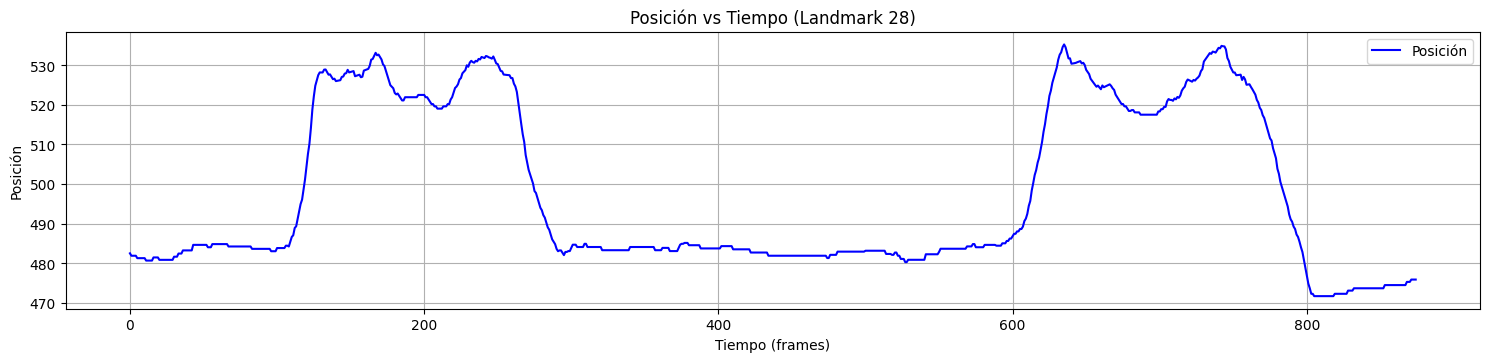

Datos de los landmarks 26 y 28 guardados en: output\tracked_landmarks.csv


In [2]:
import pandas as pd
import numpy as np
import math
import os
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# Cargar el CSV original con todos los landmarks trackeados
csv_file_path = 'output/tracked_landmarks.csv'
df = pd.read_csv(csv_file_path)

landmark_id1 = 26
landmark_id2 = 28

# Filtrar solo las filas donde landmark_id es 26 y 28
df_landmark1 = df[df['landmark_id'] == landmark_id1]
df_landmark2 = df[df['landmark_id'] == landmark_id2]

# Pivotar los datos para que cada fila contenga las coordenadas de ambos landmarks para un mismo frame
df_pivot = df.pivot(index='frame', columns='landmark_id', values=['x', 'y'])

# Renombrar las columnas para mayor claridad
df_pivot.columns = ['x_26', 'x_28', 'y_26', 'y_28']

# Aplicar el filtro gaussiano a las coordenadas x e y de ambos landmarks
df_pivot['x_26'] = gaussian_filter1d(df_pivot['x_26'], sigma=2)
df_pivot['x_28'] = gaussian_filter1d(df_pivot['x_28'], sigma=2)
df_pivot['y_26'] = gaussian_filter1d(df_pivot['y_26'], sigma=2)
df_pivot['y_28'] = gaussian_filter1d(df_pivot['y_28'], sigma=2)

# Calcular la distancia euclidiana entre los landmarks 26 y 28 para cada frame
df_pivot['distance'] = df_pivot.apply(lambda row: math.sqrt((row['x_26'] - row['x_28'])**2 + (row['y_26'] - row['y_28'])**2), axis=1)

# Resetear el índice para que el DataFrame esté en un formato plano
df_pivot.reset_index(inplace=True)

# Filtrar solo las filas donde landmark_id es 28
df_landmark_28 = df[df['landmark_id'] == 28]

# Pivotar los datos para que cada fila contenga las coordenadas del landmark 28 para un mismo frame
df_pivot_28 = df_landmark_28.pivot(index='frame', columns='landmark_id', values=['x', 'y'])

# Renombrar las columnas para mayor claridad
df_pivot_28.columns = ['x_28', 'y_28']

# Aplicar el filtro gaussiano a las coordenadas x e y del landmark 28
df_pivot_28['x_28'] = gaussian_filter1d(df_pivot_28['x_28'], sigma=2)
df_pivot_28['y_28'] = gaussian_filter1d(df_pivot_28['y_28'], sigma=2)

# Calcular la posición (distancia desde el origen)
df_pivot_28['position'] = np.sqrt(df_pivot_28['x_28']**2 + df_pivot_28['y_28']**2)

# Calcular la velocidad (diferencia de posición entre frames)
df_pivot_28['velocity'] = df_pivot_28['position'].diff()  # Velocidad como cambio en la posición
df_pivot_28['time'] = df_pivot_28.index  # Suponiendo que cada frame representa un tiempo unitario

# Calcular la aceleración (diferencia de velocidad entre frames)
df_pivot_28['acceleration'] = df_pivot_28['velocity'].diff()  # Aceleración como cambio en la velocidad

# Graficar posición, velocidad y aceleración del landmark 28
plt.figure(figsize=(15, 10))

# Gráfico de posición
plt.subplot(3, 1, 1)
plt.plot(df_pivot_28['time'], df_pivot_28['position'], label='Posición', color='blue')
plt.title('Posición vs Tiempo (Landmark 28)')
plt.xlabel('Tiempo (frames)')
plt.ylabel('Posición')
plt.grid()
plt.legend()

# Ajustar el layout y mostrar los gráficos
plt.tight_layout()
plt.show()
# Guardar el DataFrame resultante en el mismo archivo CSV
output_folder = "output"
os.makedirs(output_folder, exist_ok=True)
csv_file_path_landmark = os.path.join(output_folder, 'tracked_landmarks.csv')
df_pivot.to_csv(csv_file_path_landmark, index=False)

print(f"Datos de los landmarks 26 y 28 guardados en: {csv_file_path_landmark}")

In [3]:
# Cargar el CSV original con todos los landmarks trackeados
csv_file_path = 'output/tracked_landmarks.csv'
df = pd.read_csv(csv_file_path)
numero = float(input("ingrese valor en centimetros de la pierna"))
# Calcular la distancia promedio de todas las distancias
valor_distancia_promedio = float(df['distance'].mean())
convertidor = float(numero/valor_distancia_promedio)

# Calcular las columnas X, Y y ángulo
df['X'] = np.abs(df['x_28'] - df['x_26'])  # Asegurar que X sea >= 0
df['Y'] = np.abs(df['y_28'] - df['y_26'])  # Asegurar que Y sea >= 0

df['ángulo_26_28'] = gaussian_filter1d(np.arctan2(df['X'], df['Y']) * (180 / np.pi), sigma = 5)  # Convertir de radianes a grados y suavizarlo con un filtro gaussiano

# Remover las columnas 'X' e 'Y'
df.drop(['X', 'Y'], axis=1, inplace=True)

output_folder = "output"
os.makedirs(output_folder, exist_ok=True)
csv_file_path = os.path.join(output_folder, 'tracked_landmarks.csv')
df.to_csv(csv_file_path, index=False)



In [4]:

import pandas as pd
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# Cargar el CSV con las coordenadas y frames del trackeo
df_nuevo = pd.read_csv('output/tracked_landmarks.csv')

# FPS del video
cap = cv2.VideoCapture("vid/videotracker.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)

# Extraer la columna 'frame' del CSV de trackeo
frames = df_nuevo['frame']

# Calcular el tiempo correspondiente a cada frame
# Tiempo en segundos = frame / FPS
tiempos = frames / fps

# Añadir los tiempos al dataframe 'df_nuevo'
df_nuevo['time_seconds'] = tiempos

# Aplicar un filtro gaussiano al ángulo para suavizar
df_nuevo['ángulo_26_28'] = gaussian_filter1d(df_nuevo['ángulo_26_28'], sigma=10)
df_nuevo['ángulo_26_28'] = (df_nuevo['ángulo_26_28']*np.pi)/180
# Calcular la velocidad angular (derivada del ángulo)
velocidad_angular = (df_nuevo['ángulo_26_28'].diff() / df_nuevo['time_seconds'].diff())
df_nuevo['velocidad_angular'] = velocidad_angular

# Calcular la aceleración angular (derivada de la velocidad angular)
aceleracion_angular = gaussian_filter1d(df_nuevo['velocidad_angular'].diff() / df_nuevo['time_seconds'].diff(), sigma=20)
df_nuevo['aceleracion_angular'] = aceleracion_angular

# Guardar el dataframe actualizado
new_csv_file_path = 'output/tracked_landmarks.csv'
df_nuevo.to_csv(new_csv_file_path, index=False)


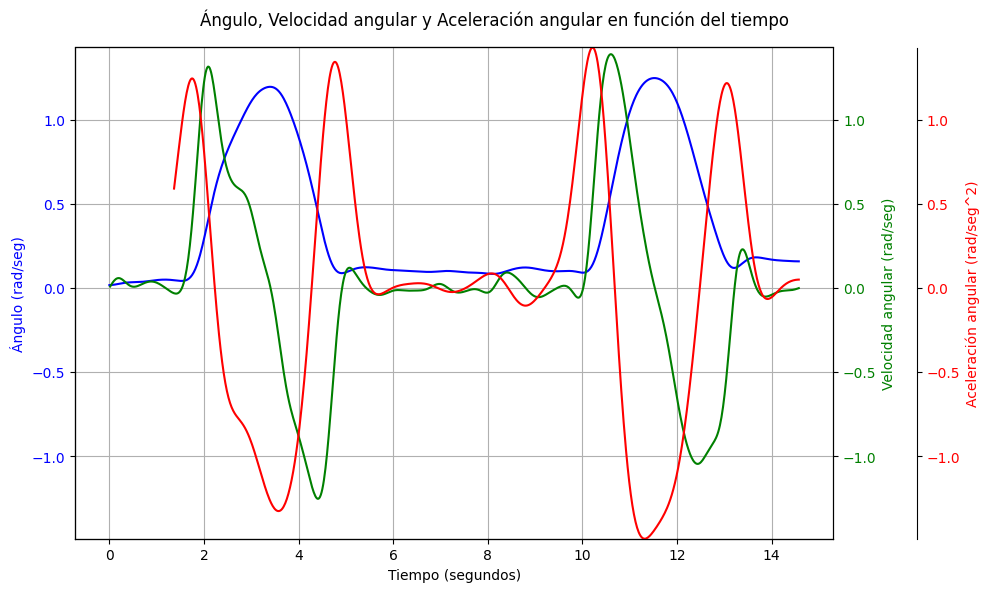

In [5]:
####SECCiÓN DE GRAFICO####

##### Cargar el CSV con las coordenadas y frames del trackeo
df_nuevo = pd.read_csv('output/tracked_landmarks.csv')
# Encontrar el valor mínimo entre todas las variables para alinear los ceros
min_y = min(df_nuevo['ángulo_26_28'].min(), df_nuevo['velocidad_angular'].min(), df_nuevo['aceleracion_angular'].min())
max_y = max(df_nuevo['ángulo_26_28'].max(), df_nuevo['velocidad_angular'].max(), df_nuevo['aceleracion_angular'].max())

# Crear el gráfico con múltiples ejes para cada variable
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar el ángulo en el eje principal (ax1)
ax1.plot(df_nuevo['time_seconds'], df_nuevo['ángulo_26_28'], color='blue', label='Ángulo')
ax1.set_xlabel('Tiempo (segundos)')
ax1.set_ylabel('Ángulo (rad/seg)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(min_y, max_y)  # Alinear el eje y con el valor mínimo común

# Crear un segundo eje para la velocidad angular
ax2 = ax1.twinx()
ax2.plot(df_nuevo['time_seconds'], df_nuevo['velocidad_angular'], color='green', label='Velocidad angular')
ax2.set_ylabel('Velocidad angular (rad/seg)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(min_y, max_y)  # Alinear el eje y con el valor mínimo común

# Crear un tercer eje para la aceleración angular
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Separar un poco el tercer eje
ax3.plot(df_nuevo['time_seconds'], df_nuevo['aceleracion_angular'], color='red', label='Aceleración angular')
ax3.set_ylabel('Aceleración angular (rad/seg^2)', color='red')
ax3.tick_params(axis='y', labelcolor='red')
ax3.set_ylim(min_y, max_y)  # Alinear el eje y con el valor mínimo común

# Título y leyendas
fig.suptitle('Ángulo, Velocidad angular y Aceleración angular en función del tiempo')
ax1.grid(True)

fig.tight_layout()
plt.show()


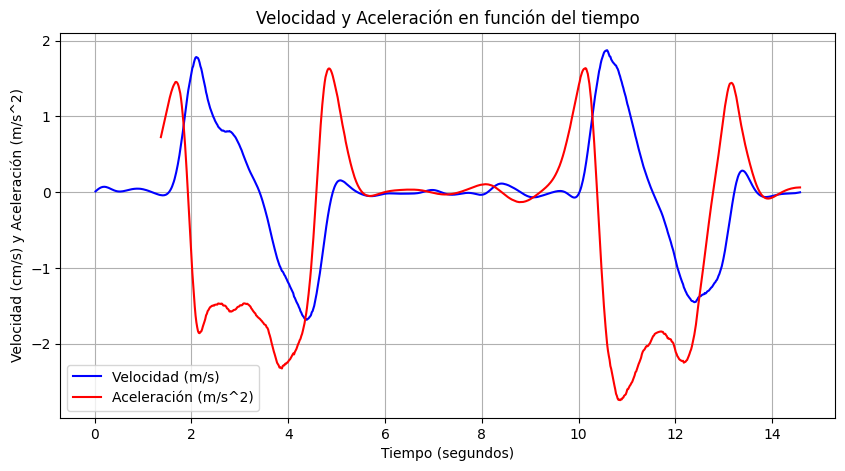

In [6]:
##Se consigue la velocidad y aceleración en cm/s y cm/s^2
import pandas as pd
# Se abre el CSV con lo trackeado y los ángulos
csv_file_path = 'output/tracked_landmarks.csv'
df = pd.read_csv(csv_file_path)
velocidad = df['distance']/100 * df['velocidad_angular']
# agregar velocidad_angular al dataframe
df['velocidad'] = velocidad
aceleracion = -df['distance']/100 * df['velocidad_angular']**2 + df['distance']/100 * df['aceleracion_angular']
df['aceleracion']=aceleracion
df.to_csv('output/tracked_landmarks.csv', index=False)
import matplotlib.pyplot as plt

# Suponiendo que el DataFrame ya tiene una columna 'tiempo' y 'angulo_26_28'
# Si no, asegúrate de agregarla o calcularla antes de graficar

# Graficar velocidad y aceleración en función del tiempo en el mismo gráfico
plt.figure(figsize=(10, 5))

# Graficar velocidad
plt.plot(df['time_seconds'], df['velocidad'], label='Velocidad (m/s)', color='blue')

# Graficar aceleración
plt.plot(df['time_seconds'], df['aceleracion'], label='Aceleración (m/s^2)', color='red')

plt.xlabel('Tiempo (segundos)')
plt.ylabel('Velocidad (cm/s) y Aceleración (m/s^2)')
plt.title('Velocidad y Aceleración en función del tiempo')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import cv2
import math
import pandas as pd
import os
import mediapipe as mp
import numpy as np

# Variables para coordenadas y flags
x1, y1, x2, y2 = 0, 0, 0, 0
flag_click1, flag_click2 = False, False

def distancia_landmark(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def click_distancia1(event, x, y, flags, params):
    global x1, y1, flag_click1
    if event == cv2.EVENT_LBUTTONDOWN:
        x1, y1 = x, y
        flag_click1 = True

def click_distancia2(event, x, y, flags, params):
    global x2, y2, flag_click2
    if event == cv2.EVENT_LBUTTONDOWN:
        x2, y2 = x, y
        flag_click2 = True

def click_event(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        print('Posición en X:', x, 'Posición en Y:', y)
    if event == cv2.EVENT_RBUTTONDOWN:
        print(x, ' ', y)

# Inicializar MediaPipe Pose y las utilidades de dibujo
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Se abre el video
cap = cv2.VideoCapture("vid/videotracker.mp4")

# Se abre el CSV con lo trackeado y los ángulos
csv_file_path = 'output/tracked_landmarks.csv'
df = pd.read_csv(csv_file_path)

# Variable de pausa
is_paused = False
last_frame = None

# Se crean dos listas vacías para almacenar las coordenadas de cada landmark
coordenadas_landmark_26 = []
coordenadas_landmark_28 = []

# Obtener FPS del video
fps = cap.get(cv2.CAP_PROP_FPS)
wait_time = int(1000 / fps)  # Tiempo en milisegundos entre frames

# Resizear la ventana
cv2.namedWindow("frame", cv2.WINDOW_NORMAL)
frame_count = 0

# Función para calcular el vector tangencial normalizado
def calcular_vector_tangencial_normalizado(x1, y1, x2, y2, magnitud_deseada):
    # Calcular el vector director radial
    dx = x2 - x1
    dy = y2 - y1
    norma = math.sqrt(dx**2 + dy**2)
    
    # Normalizar los componentes
    dx /= norma
    dy /= norma

    # Calcular el vector tangencial normalizado (perpendicular)
    tangencial_x_pos = -dy  # Positivo
    tangencial_y_pos = dx   # Positivo

    tangencial_x_neg = dy   # Negativo
    tangencial_y_neg = -dx  # Negativo

    # Escalar el vector tangencial a la magnitud deseada
    tangencial_x_pos *= magnitud_deseada
    tangencial_y_pos *= magnitud_deseada

    tangencial_x_neg *= magnitud_deseada
    tangencial_y_neg *= magnitud_deseada

    return (tangencial_x_pos, tangencial_y_pos), (tangencial_x_neg, tangencial_y_neg)
def calcular_vector_tangencial(x1, y1, x2, y2, magnitud_deseada):
    # Calcular el vector director radial
    dx = x2 - x1
    dy = y2 - y1

    # Calcular el vector tangencial normalizado (perpendicular)
    tangencial_x_pos = -dy  # Positivo
    tangencial_y_pos = dx   # Positivo

    tangencial_x_neg = dy   # Negativo
    tangencial_y_neg = -dx  # Negativo

    # Escalar el vector tangencial a la magnitud deseada
    tangencial_x_pos *= magnitud_deseada
    tangencial_y_pos *= magnitud_deseada

    tangencial_x_neg *= magnitud_deseada
    tangencial_y_neg *= magnitud_deseada

    return (tangencial_x_pos, tangencial_y_pos), (tangencial_x_neg, tangencial_y_neg)
while True:
    if not is_paused:
        ret, frame = cap.read()
        if not ret:
            break
        last_frame = frame  # Guarda el último frame válido
    else:
        frame = last_frame  # Muestra el último frame cuando está en pausa

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Obtener las coordenadas de los landmarks y el ángulo para el frame actual
    row = df.iloc[frame_count]
    x_26 = int(row['x_26'])
    y_26 = int(row['y_26'])
    radio = int(row['distance'])
    cv2.circle(frame, (x_26, y_26), radio, (255, 0, 0), 2)

    if frame_count < len(df):
        row = df.iloc[frame_count]

        # Extraer las coordenadas del landmark 26
        x_26 = row['x_26']
        y_26 = row['y_26']
        coordenadas_landmark_26.append((x_26, y_26))

        # Extraer las coordenadas del landmark 28
        x_28 = row['x_28']
        y_28 = row['y_28']
        coordenadas_landmark_28.append((x_28, y_28))

        # Extraer el ángulo pre-calculado
        angle = row['ángulo_26_28']

        # Graficar el vector r desde landmark 26 a 28
        cv2.arrowedLine(frame, (int(x_26), int(y_26)), (int(x_28), int(y_28)), (255, 255, 255), 2, tipLength=0.1)
        
        # Añadir el texto 'r' en la mitad del vector r
        x_r_mid = int((x_26 + x_28) / 2)
        y_r_mid = int((y_26 + y_28) / 2)
        cv2.putText(frame, 'r', (x_r_mid, y_r_mid), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        # Llama a la función para calcular los vectores tangenciales normalizados
        magnitud_deseada = 50  # Puedes ajustar esta magnitud según lo que necesites
        (tangencial_pos, tangencial_neg) = calcular_vector_tangencial_normalizado(x_26, y_26, x_28, y_28, magnitud_deseada)

        # Desempaquetar los valores de los vectores tangenciales
        tangencial_x_pos, tangencial_y_pos = tangencial_pos
        tangencial_x_neg, tangencial_y_neg = tangencial_neg

        # Punto final del vector tangencial (dirección positiva)
        x_tangencial_pos = int(x_28 + tangencial_x_pos)
        y_tangencial_pos = int(y_28 + tangencial_y_pos)

        # Punto final del vector tangencial (dirección negativa)
        x_tangencial_neg = int(x_28 + tangencial_x_neg)
        y_tangencial_neg = int(y_28 + tangencial_y_neg)

        # Ahora puedes graficar los vectores tangenciales
        cv2.arrowedLine(frame, (int(x_28), int(y_28)), (x_tangencial_pos, y_tangencial_pos), (100, 255, 0), 1, tipLength=0.1)
        cv2.arrowedLine(frame, (int(x_28), int(y_28)), (x_tangencial_neg, y_tangencial_neg), (100, 255, 0), 1, tipLength=0.1)
        
########GRAFICO VECTOR VELOCIDAD
        # Extraer un valor escalar de df['velocidad']
        magnitud_deseada = df['velocidad'].iloc[frame_count] # Cambia el índice si es necesario

        # Calcular la dirección del vector tangencial (dirección positiva)
        direccion_x = tangencial_x_pos
        direccion_y = tangencial_y_pos


        # Escalar la dirección a la magnitud deseada
        if magnitud_deseada == 0:
            # Si la magnitud deseada es 0, no se grafica el vector
            x_vector_velocidad = int(x_28)  # Mantener el punto original
            y_vector_velocidad = int(y_28)
        else:
            # Si la magnitud es positiva o negativa, calcular la dirección escalada
            direccion_x *= abs(magnitud_deseada)
            direccion_y *= abs(magnitud_deseada)
            if not math.isnan(direccion_x) and not math.isnan(direccion_y):
                if magnitud_deseada < 0:
                    x_vector_velocidad = int(x_28 + direccion_x)
                    y_vector_velocidad = int(y_28 + direccion_y)
                else:
                    x_vector_velocidad = int(x_28 - direccion_x)
                    y_vector_velocidad = int(y_28 - direccion_y)
            else:
                x_vector_velocidad = int(x_28)
                y_vector_velocidad = int(y_28)

        # Graficar el vector de velocidad solo si la magnitud es diferente de 0
        if magnitud_deseada != 0:
            cv2.arrowedLine(frame, (int(x_28), int(y_28)), (x_vector_velocidad, y_vector_velocidad), (255, 0, 255), 1, tipLength=0.3)

            # Añadir texto 'v' cerca del final del vector de velocidad
            cv2.putText(frame, 'Vel', (x_vector_velocidad, y_vector_velocidad), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)
########FIN GRAFICO VECTOR VELOCIDAD
########GRAFICO VECTOR ACELERACION
        # Extraer un valor escalar de df['aceleracion']
        magnitud_deseada = df['aceleracion'].iloc[frame_count] # Cambia el índice si es necesario

        # Calcular la dirección del vector tangencial (dirección positiva)
        direccion_x = tangencial_x_pos
        direccion_y = tangencial_y_pos

        # Escalar la dirección a la magnitud deseada
        if magnitud_deseada == 0:
            # Si la magnitud deseada es 0, no se grafica el vector
            x_vector_aceleracion = int(x_28)  # Mantener el punto original
            y_vector_aceleracion = int(y_28)
        else:
            # Si la magnitud es positiva o negativa, calcular la dirección escalada
            direccion_x *= abs(magnitud_deseada)
            direccion_y *= abs(magnitud_deseada)
            if not math.isnan(direccion_x) and not math.isnan(direccion_y):
                if magnitud_deseada < 0:
                    x_vector_aceleracion = int(x_28 + direccion_x)
                    y_vector_aceleracion = int(y_28 + direccion_y)
                else:
                    x_vector_aceleracion = int(x_28 - direccion_x)
                    y_vector_aceleracion = int(y_28 - direccion_y)
            else:
                x_vector_aceleracion = int(x_28)
                y_vector_aceleracion = int(y_28)

        # Graficar el vector de aceleracion solo si la magnitud es diferente de 0
        if magnitud_deseada != 0:
            cv2.arrowedLine(frame, (int(x_28), int(y_28)), (x_vector_aceleracion, y_vector_aceleracion), (0, 255, 255), 1, tipLength=0.3)

            # Añadir texto 'a' cerca del final del vector de aceleracion
            cv2.putText(frame, 'Acel', (x_vector_aceleracion, y_vector_aceleracion), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
########FIN GRAFICO VECTOR ACELERACION

        # Añadir el texto 'eθ+' y 'eθ-' cerca del final de ambos vectores tangenciales
        cv2.putText(frame, 'e0-', (x_tangencial_pos, y_tangencial_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, 'e0+', (x_tangencial_neg, y_tangencial_neg), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        # Definir la longitud del vector er que deseas
        longitud_er = 200  
        # Calcular el vector radial (er) direccional con magnitud fija
        vector_radial_x = x_28 - x_26
        vector_radial_y = y_28 - y_26
        norma_radial = math.sqrt(vector_radial_x**2 + vector_radial_y**2)

        # Normalizar el vector radial
        vector_radial_x /= norma_radial
        vector_radial_y /= norma_radial

        # Escalar el vector radial a la longitud deseada
        x_radial = int(x_26 + vector_radial_x * longitud_er)
        y_radial = int(y_26 + vector_radial_y * longitud_er)

        # Graficar el vector radial (er) con la nueva magnitud fija
        cv2.arrowedLine(frame, (int(x_28), int(y_28)), (x_radial, y_radial), (0, 0, 255), 1, tipLength=0.1)

        # Añadir el texto 'er' cerca del final del vector radial
        cv2.putText(frame, 'er', (x_radial, y_radial), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.imshow("frame", frame)
        cv2.setMouseCallback('frame', click_event)

        # Verifica la entrada del teclado
        key = cv2.waitKey(wait_time) & 0xFF

        # Pausar o reanudar
        if key == ord('p'):
            is_paused = not is_paused

        # Manejando la tecla 'd' para capturar coordenadas
        if key == ord('d'):
            flag_click1 = False
            flag_click2 = False
            print('Click en primer punto')

            # Asegúrate de capturar los clics sin detener el ciclo principal
            while not flag_click1:
                cv2.setMouseCallback('frame', click_distancia1)
                cv2.waitKey(1)  # Permitir que OpenCV procese eventos

            print('Click en segundo punto')
            while not flag_click2:
                cv2.setMouseCallback('frame', click_distancia2)
                cv2.waitKey(1)

            distancia = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            print(f'La distancia es de: {distancia} (en píxeles)')

        # Salir del ciclo con la tecla 'Esc'
        if key == 27:
            break

        # Solo avanza los frames cuando no está en pausa
        if not is_paused:
            frame_count += 1
# Liberar los recursos al finalizar
cap.release()
cv2.destroyAllWindows()